In [55]:
"""Import everything we need and check gpu"""
%matplotlib inline

already_installed = !pip list -v | grep deeptrack
if not already_installed:
    !pip install deeptrack==1.0.1
    !pip install mat73

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import deeptrack as dt
import tensorflow.keras as keras
import mat73
from matplotlib import colors
from cycler import cycler
from google.colab import drive

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)    
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

def save_models(models):
    drive.mount('/content/drive')
    for i, model in enumerate(models):
        model.save(save_model_path+f"model{i}")

def load_models(path, NUMBER_OF_MODELS):
    """Load models and return them in a list"""
    drive.mount('/content/drive')
    return [models.load_model(path+f"/model{i}") for i in range(NUMBER_OF_MODELS)]

Fri Mar 25 21:58:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    32W / 250W |    855MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [56]:
"""Import the validation set"""
""" Function to import used to unpack rows of FFT-field"""
def exp_expand(data,shape):
    x = np.arange(shape[0]) - shape[0] / 2
    y = np.arange(shape[1]) - shape[1] / 2
    X, Y = np.meshgrid(x, y)
    bg=np.zeros((shape[0]*shape[1],))+0j
    X=np.reshape(np.fft.fftshift(X),(shape[0]*shape[1]))
    Y=np.reshape(np.fft.fftshift(Y),(shape[0]*shape[1]))
    RHO=X**2+Y**2
    Inds=np.argsort(RHO)
    Inds=np.sort(Inds[:data.shape[0]])

    bg[Inds[:data.shape[0]]]=data
    bg=np.reshape(bg,(shape[0],shape[1]))
  
    return bg

drive.mount('/content/drive')
filePath = "/content/drive/My Drive/valset/valset_1.mat"

data = mat73.loadmat(filePath)
data = data['CompletedTraces']

shape = [64, 64]
realM = np.zeros((len(data), 64, 64, 1))
imagM = 1j * np.ones((len(data), 64, 64, 1))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


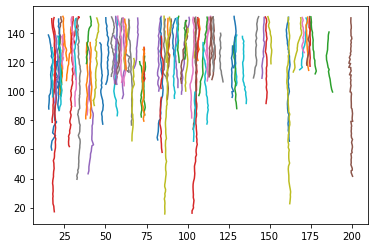

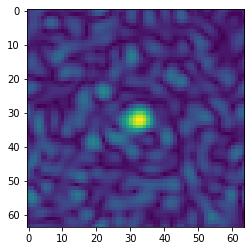

In [57]:
"""Saves images and positions for individual particles."""
particles_timeseries = []
particles_positions = []
num_particles = 100
IMAGE_SIZE = 64

for i in range(num_particles):
    frames = data[i]["Positions"][:,0].astype(int)
    positions = data[i]["Positions"][:,1:4]
    particles_positions.append(positions)

    roi_data = np.array(data[i]['ROI'][0])
    timeseries = []
    for j in range(roi_data.shape[0]):
        particleROI = np.fft.ifft2(exp_expand(roi_data[j,:], shape))
        particleROI = np.fft.fftshift(particleROI)
        particleROI = np.expand_dims(particleROI, axis = -1)
        timeseries.append(particleROI)
    particles_timeseries.append(np.array(timeseries))

for particle_id in range(num_particles):
    plt.plot(particles_positions[particle_id][:,0], particles_positions[particle_id][:,1])
plt.show()

for _ in range(1):
    plt.imshow(np.abs(particles_timeseries[0][_,:,:,0]))
    plt.show()

training images shape (13, 64, 64, 2)
validation images shape (64, 64, 64, 1)


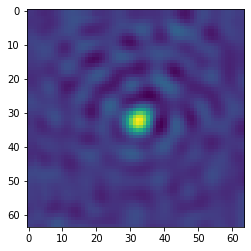

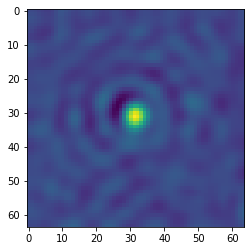

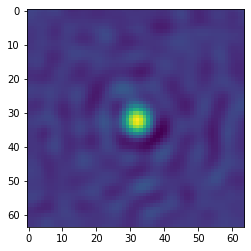

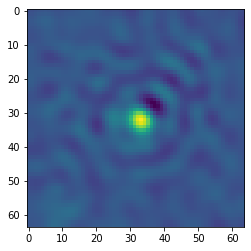

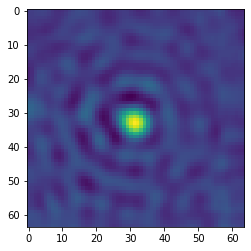

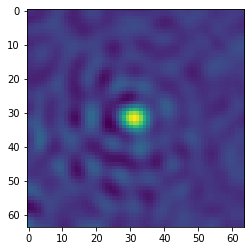

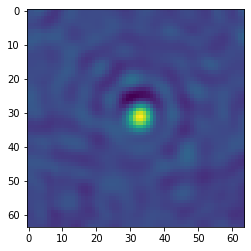

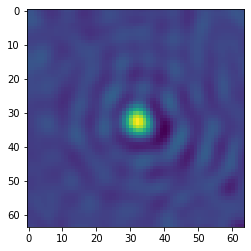

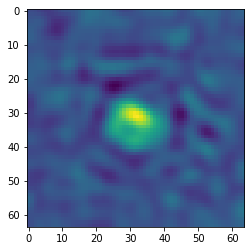

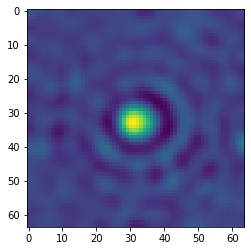

In [58]:
particle_id = 10
training_images = np.stack((np.real(particles_timeseries[particle_id])[::5,:,:,0], np.imag(particles_timeseries[particle_id][::5,:,:,0])), axis=-1)
print(f"training images shape {training_images.shape}")
validation_set = particles_timeseries[particle_id][:,:,:,:]
print(f"validation images shape {validation_set.shape}")

"""Create group/equivariance"""

crop_size = 64
padding = 32
wavelength = 525e-9
pixel_size = 114e-9 #??
crop_propagation_forward = dt.get_propagation_matrix((crop_size + 2 * padding, ) * 2, 1e-7, pixel_size * 2, wavelength)
crop_propagation_backward = dt.get_propagation_matrix((crop_size + 2 * padding, ) * 2, -1e-7, pixel_size * 2, wavelength)

args = dt.Arguments(
    translate=lambda: np.random.randn(2)*0.5,
    rotate=lambda: np.random.uniform(0, np.pi*2),
    z=lambda: np.random.randn(1)*20,
)

group = ( 
    dt.Affine(rotate=args.rotate) 
    >> dt.Affine(translate=args.translate) 
    >> dt.Gaussian(sigma=lambda: np.random.rand() * 0.00)
    >> dt.FourierTransform() 
    >> dt.FourierTransformTransformation(crop_propagation_forward, crop_propagation_backward, args.z) 
    >> dt.InverseFourierTransform() 
)

equivariance = (
    dt.models.lodestar.Rotational2DEquivariance(args.rotate)
    >> dt.models.lodestar.TranslationalEquivariance(args.translate)
    >> dt.models.lodestar.Equivariance(1, args.z/10, indexes=2)
)

import random
def create_training_set(training_images):
    return dt.Value(lambda: random.choice(training_images))

training_set = create_training_set(training_images)

for _ in range(10):
    x = (training_set>>group).update()()
    plt.imshow(x[..., 1])
    plt.show()


In [59]:
#@title
"""Create custom layers"""
from tensorflow.math import abs, angle, real, imag, subtract, multiply

class CustomLayerOne(keras.layers.Layer):
    "Dpes nothing"
    def __init__(self):
        super().__init__()

    def build( self, input_shape):
        super().build(input_shape)

    def call(self, image):
        image = tf.dtypes.complex(image[...,0], image[...,1])
        norm_image = subtract(image, 1)
        return tf.stack([real(norm_image), imag(norm_image), angle(image)], axis=-1)#tf.stack([abs(norm_image), angle(image), real(norm_image), imag(norm_image)], axis=-1)

class CustomLayerTwo(keras.layers.Layer):
    "Takes 2 layers as input and outputs 3 layers."
    def __init__(self):
        super().__init__()

    def build( self, input_shape):
        super().build(input_shape)

    def call(self, image):
        image = tf.dtypes.complex(image[...,0], image[...,1])
        norm_image = subtract(image, 1)
        return tf.stack([real(norm_image), imag(norm_image), abs(norm_image)], axis=-1)#tf.stack([abs(norm_image), angle(image), real(norm_image), imag(norm_image)], axis=-1)

class CustomLayerThree(keras.layers.Layer):
    "Takes 2 layers as input and outputs 4 layers."
    def __init__(self):
        super().__init__()

    def build( self, input_shape):
        super().build(input_shape)

    def call(self, image):
        image = tf.dtypes.complex(image[...,0], image[...,1])
        norm_image = subtract(image, 1)
        return tf.stack([abs(norm_image), angle(image), real(norm_image), imag(norm_image)], axis=-1)


In [60]:
#@title
"""Create models"""
num_outputs = 3

def create_model(custom_layer, nlayers):
    model = keras.models.Sequential()
    model.add(keras.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,2)))
    model.add(custom_layer)
    model.add(keras.layers.Conv2D(32, 3, activation='relu', strides=(2,2)))
    for _ in range(nlayers):
        model.add(keras.layers.Conv2D(64, 3, activation='relu'))
    model.add(keras.layers.Conv2D(num_outputs+1,1))
    model = dt.models.LodeSTAR(model=model, input_shape=(None, None, 2), num_outputs=num_outputs)
    model.specs = {"Layers": nlayers}
    model.totalhistory = {"total_loss":[], "consistency_loss":[]}
    model.compile(loss=["mae", "mae", "mae"], optimizer=tf.keras.optimizers.Adam(), loss_weights=[1, 1, 1])
    return model

models = [create_model(CustomLayerThree(), 1)]


In [61]:
"""Create generator"""
generator = dt.models.lodestar.LodeSTARGenerator(
    training_set,
    num_outputs=num_outputs, 
    transformation_function=(group, equivariance), 
    batch_size=8, 
    min_data_size=100, 
    max_data_size=201,
)

Generating 200 / 100 samples before starting training


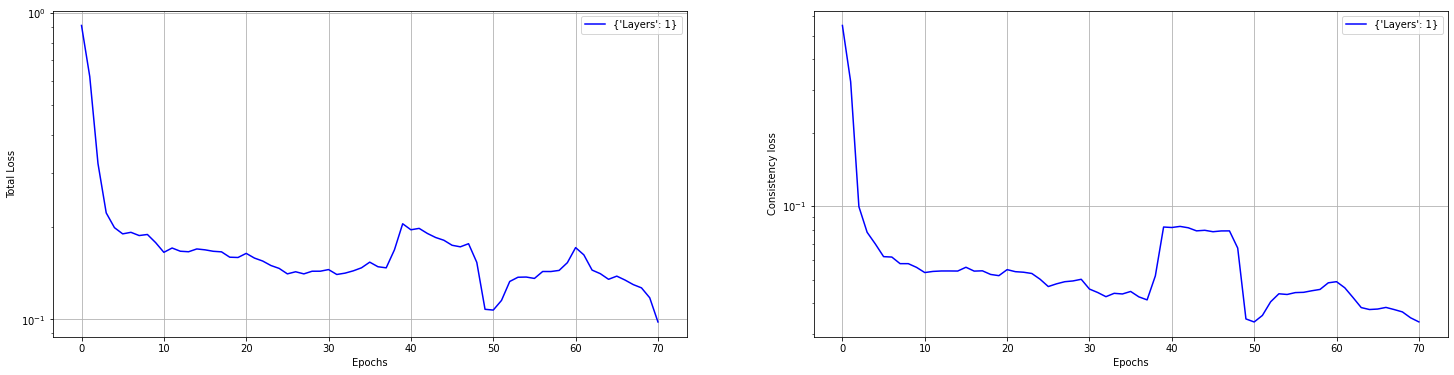

Generating 201 / 100 samples before starting training


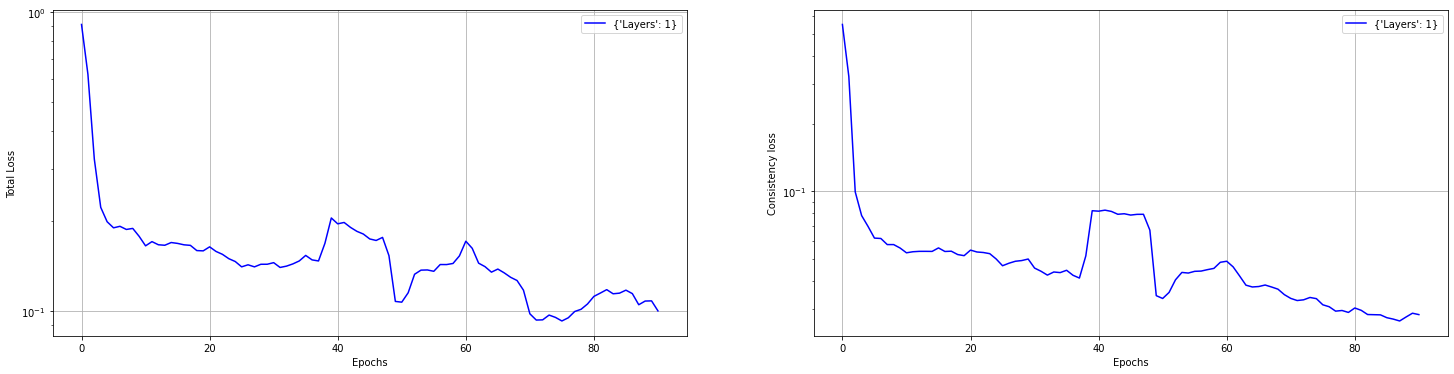

Generating 200 / 100 samples before starting training


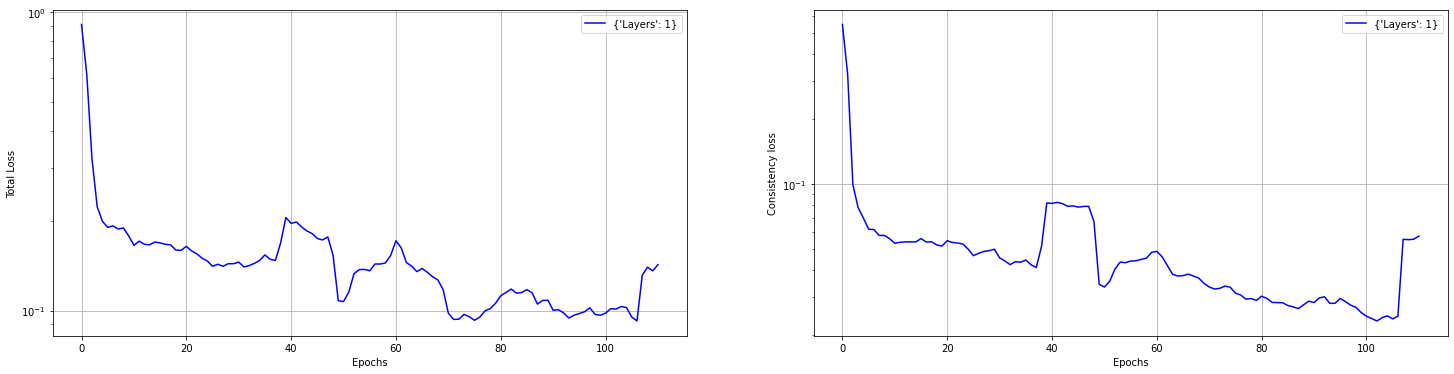

In [69]:
def save_progress(model, h):
    model.totalhistory["total_loss"].extend(h.history["total_loss"])
    model.totalhistory["consistency_loss"].extend(h.history["consistency_loss"])

def plot_progress(models):
    def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'valid') / w

    cc = (cycler(color=list('bgrcmyk')))
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(25,6))
    ax1.set_prop_cycle(cc)
    ax2.set_prop_cycle(cc)

    for i, model in enumerate(models):
        ax1.plot(moving_average(model.totalhistory["total_loss"], 10), label=f"{model.specs}")
        ax1.set_xlabel("Epochs")
        ax1.set_ylabel("Total Loss")
        ax1.set_yscale("log")
        ax1.legend()

        ax2.plot(moving_average(model.totalhistory["consistency_loss"], 10), label=f"{model.specs}")
        ax2.set_xlabel("Epochs")
        ax2.set_ylabel("Consistency loss")
        ax2.set_yscale("log")
        ax2.legend()

    ax1.grid(True)
    ax2.grid(True)
    plt.show()

for _ in range(10):
    with generator:
        for model in models:
            h = model.fit(generator, epochs=20, steps_per_epoch=100, verbose=0)
            save_progress(model, h)
        plot_progress(models)
        



In [70]:
for model in models:
    print(model.specs)
    model.summary()


{'Layers': 1}
Model: "lode_star_base_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 29, 29, 4)         19940     
                                                                 
Total params: 19,940
Trainable params: 19,940
Non-trainable params: 0
_________________________________________________________________


In [71]:
def get_propagation_matrix(shape, to_z, pixel_size, wavelength):

    k = 2 * np.pi / wavelength
    yr, xr, *_ = shape

    x = 2 * np.pi / pixel_size * np.arange(-(xr / 2 - 1 / 2), (xr / 2 + 1 / 2), 1) / xr
    y = 2 * np.pi / pixel_size * np.arange(-(yr / 2 - 1 / 2), (yr / 2 + 1 / 2), 1) / yr
    KXk, KYk = np.meshgrid(x, y)

    K = np.real(
        np.sqrt(np.array(1 - (KXk / k) ** 2 - (KYk / k) ** 2, dtype=np.complex64))
    )
    C = np.fft.fftshift(((KXk / k) ** 2 + (KYk / k) ** 2 < 1) * 1.0)

    return C * np.fft.fftshift(np.exp(k * 1j * to_z * (K - 1)))

def fourier_transform(image, padding=32):
    im = np.pad(image, ((padding, padding), (padding, padding)), mode="symmetric")
    return np.fft.fft2(im)

def inverse_fourier_transform(image, padding=32):
    im = np.fft.ifft2(image)
    return im[padding:-padding, padding:-padding]

def fourier_transform_transformation(image, Tz, Tzinv, i):
    if i < 0:
        image *= Tzinv ** np.abs(i)
    else:
        image *= Tz ** i
    return image

def propagate(image, z):
    """Re-propagate the images using PAS"""
    ft_image = fourier_transform(image[:,:,0])
    prop_ft_image = fourier_transform_transformation(ft_image, crop_propagation_backward, crop_propagation_forward, z)
    return np.expand_dims(inverse_fourier_transform(prop_ft_image),axis=-1)

{'Layers': 1}
PROPAGERADE BILDER


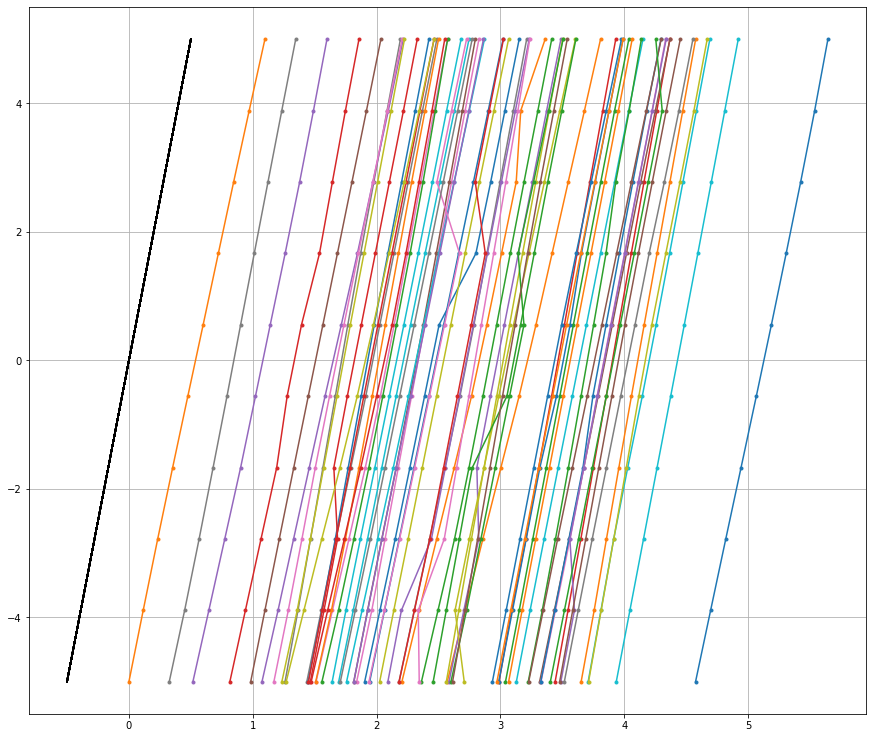

STD: 3.023


In [72]:
cc = (cycler(color=list('bgrcmyk')))

def predict_on_stack(model, val_stack):
    """returns a numpy tensor containing propagated distance as well as the prediction, for ever propagation distance and every image images"""
    try:
        dets = np.array(model.predict_and_detect(val_stack, mode="ratio"))
    except ValueError as E:
        dets = np.expand_dims(np.zeros((val_stack.shape[0],3)), axis=0)
        print(E)
    dets = reshape_dets(dets)
    dets *= multfact
    #dets[:,2] = dets[:,2] - np.mean(dets[:,2])
    return dets

def reshape_dets(dets):
    """Removes all particles but the one closest to the center. If no particles are detected, sets the value to 0."""
    out = []
    for coords in dets:
        if coords.shape != (0, 3):
            x, y = IMAGE_SIZE//2, IMAGE_SIZE//2
            idx = np.argmin(np.array(coords[:,:2]- np.array((x, y))), axis=0)[0]
            out.append(coords[idx,:])
        else:
            out.append([0,0,0])
    return np.array(out)

def create_validation_stack(images, z_list):
    """"""
    output = []
    for i in range(images.shape[0]):
        image = images[i,:,:,:]
        stack = []
        for z in z_list:
            stack.append(propagate(image, z))
        output.append(stack)
    return np.stack((np.real(output), np.imag(output)), axis=-1)[:,:,:,:,0,:]

def plot_preds(val_stack):
    for particle_id in range(from_id, from_id+num_samples):
        dets = model.predict_and_detect(val_stack[:,:,:,:], mode="ratio"), 
        plt.figure(figsize=(10, 10))
        plt.imshow(np.abs(val_stack[stack_id,:,:,0]+1j*val_stack[stack_id,:,:,1]), cmap="bone")
        dets = np.squeeze(np.array(dets))
        print(dets)
        plt.scatter(dets[stack_id,1], dets[stack_id,0], s=200, facecolor="none", linewidths=3, edgecolors="g")
        plt.show()
        
        dets[:,2] *= multfact
        #dets[:,2] -= np.mean(dets[:,2])
        #[print(d) for d in dets]

def evaluate_model(model, val_stack, prop_range):
    accs = []
    for i in range(num_samples):
        accs.append(predict_on_stack(model, val_stack[from_id+i])[:,2])
    accs = np.array(accs)
    accs = accs - np.min(accs)

    stds = []
    fig, ax = plt.subplots(1,1, figsize=(15,13))
    for i in range(accs.shape[0]):
        ax.plot(prop_range/10, prop_range, 'k')
        ax.plot(accs[i,:].flatten(), prop_range, '.-')
        ax.grid(True)
        stds.append(np.std(accs[i,:].flatten() - prop_range))
    plt.show()
    print(f"STD: {np.std((accs-prop_range).flatten()):.3f}", )

model = models[-1]
#for model in models:
prop_range = np.linspace(-5, 5, 10) #np.random.randn(70)
from_id = 0
num_samples = len(particles_positions[particle_id][:,0])
stack_id = len(prop_range)//2
multfact = -1
print(model.specs)
print("PROPAGERADE BILDER")
val_stack = create_validation_stack(validation_set, prop_range)
evaluate_model(model, val_stack, prop_range)

val_stack = np.stack( (np.real(validation_set[:,:,:,0]), np.imag(validation_set[:,:,:,0])), axis=-1)
corrections = predict_on_stack(model, val_stack)
x_lode, y_lode, z_lode = corrections[:,0], corrections[:,1], corrections[:,2]
x_matlab, y_matlab, z_matlab = particles_positions[particle_id][:,0], particles_positions[particle_id][:,1], particles_positions[particle_id][:,2]
z_lode = z_lode/-10
z_lode = z_lode - np.mean(z_lode)
x_new, y_new, z_new = x_matlab+(32+x_lode)*0.114, y_matlab+(32+y_lode)*0.114, z_lode+z_matlab


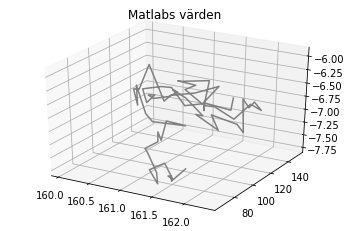

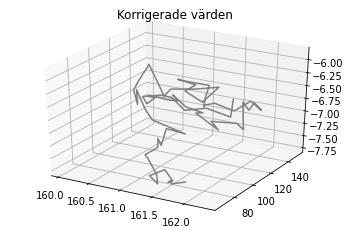

Matlab!


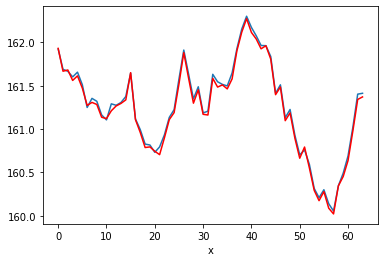

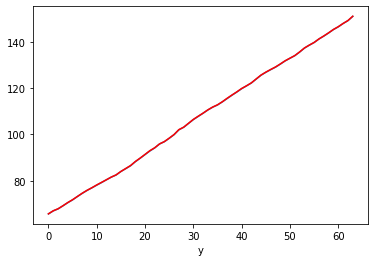

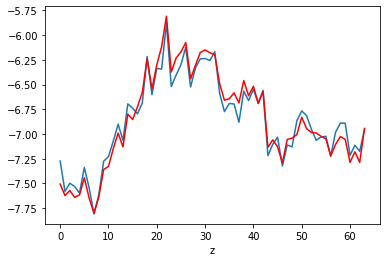

In [73]:
from mpl_toolkits import mplot3d

ax = plt.axes(projection='3d')
ax.plot3D(x_matlab, y_matlab, z_matlab, 'gray')
ax.set_title("Matlabs värden")
plt.show()

ax = plt.axes(projection='3d')
ax.plot3D(x_matlab, y_matlab, z_matlab+z_lode, 'gray')
ax.set_title("Korrigerade värden")
plt.show()

print("Matlab!")
plt.plot(list(range(len(x_matlab))), x_matlab)
plt.xlabel("x")
plt.plot(list(range(len(x_lode))), x_new, 'r')
plt.show()

plt.plot(list(range(len(y_matlab))), y_matlab)
plt.plot(list(range(len(y_lode))), y_new, 'r')
plt.xlabel("y")
plt.show()

plt.plot(list(range(len(z_matlab))), z_matlab)
plt.plot(list(range(len(z_lode))), z_new, 'r')
plt.xlabel("z")
plt.show()

#https://journals.aps.org/pre/pdf/10.1103/PhysRevE.89.022726

In [74]:
def calc_sigma(arr):
    sigma2 = np.abs(np.mean(
        np.multiply(
            np.diff(arr[:-1]), 
            np.diff(arr[1:])
            )
    ))
    return np.sqrt(sigma2)

print(f"sigma_x_new: {calc_sigma(x_new):.3f}")
print(f"sigma_x_matlab: {calc_sigma(x_matlab):.3f}")
print(f"sigma_z_new: {calc_sigma(z_new):.3f}")
print(f"sigma_z_matlab: {calc_sigma(z_matlab):.3f}")


sigma_x_new: 0.077
sigma_x_matlab: 0.085
sigma_z_new: 0.101
sigma_z_matlab: 0.138


PARTICLE ID:  0
training images shape (16, 64, 64, 2)
validation images shape (16, 64, 64, 1)
Generating 101 / 100 samples before starting training


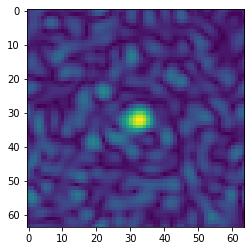

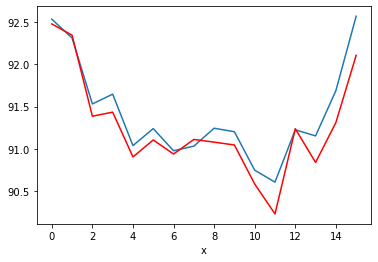

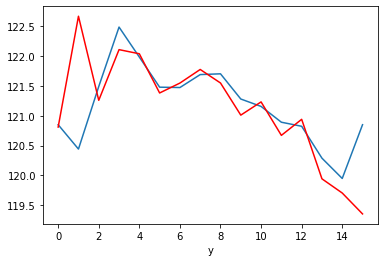

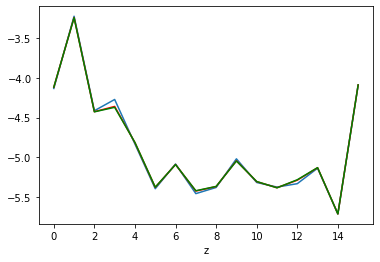

sigma_x_matlab: 0.122
sigma_x_new: 0.190

sigma_y_matlab: 0.166
sigma_y_new: 0.546

sigma_z_matlab: 0.417
sigma_z_new: 0.400
sigma_z_oil: 0.398
sigma_z_multfact: 0.391
z_mult: 7.3277741677556385

PARTICLE ID:  1
training images shape (17, 64, 64, 2)
validation images shape (17, 64, 64, 1)
Generating 101 / 100 samples before starting training


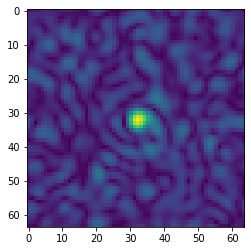

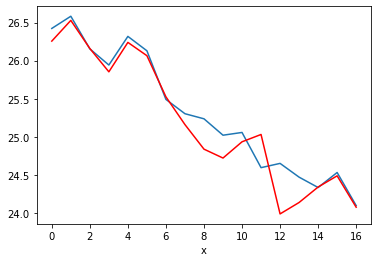

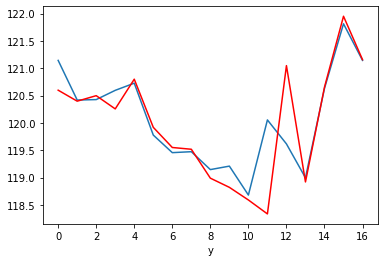

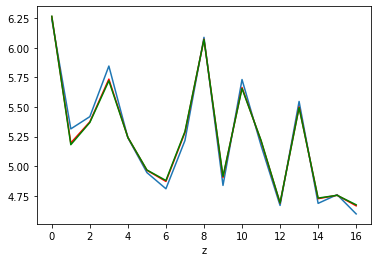

sigma_x_matlab: 0.025
sigma_x_new: 0.028

sigma_y_matlab: 0.231
sigma_y_new: 0.776

sigma_z_matlab: 0.483
sigma_z_new: 0.436
sigma_z_oil: 0.430
sigma_z_multfact: 0.410
z_mult: 5.334865318775943

PARTICLE ID:  2
training images shape (17, 64, 64, 2)
validation images shape (17, 64, 64, 1)
Generating 100 / 100 samples before starting training


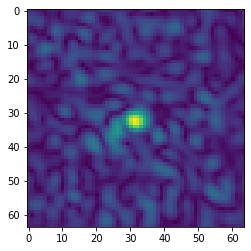

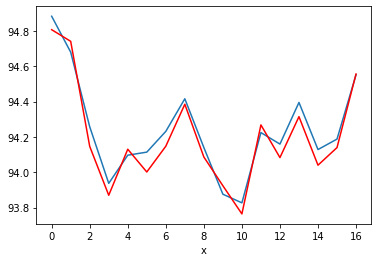

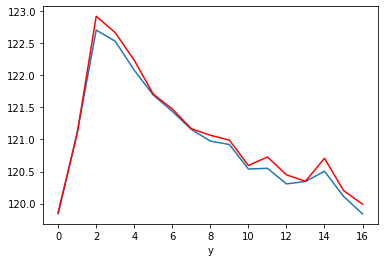

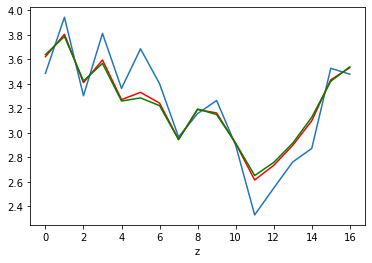

sigma_x_matlab: 0.087
sigma_x_new: 0.099

sigma_y_matlab: 0.390
sigma_y_new: 0.384

sigma_z_matlab: 0.241
sigma_z_new: 0.075
sigma_z_oil: 0.046
sigma_z_multfact: 0.067
z_mult: 2.1394951226329955

PARTICLE ID:  3
training images shape (33, 64, 64, 2)
validation images shape (33, 64, 64, 1)
Generating 101 / 100 samples before starting training


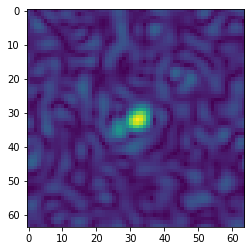

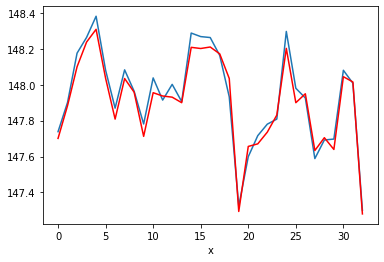

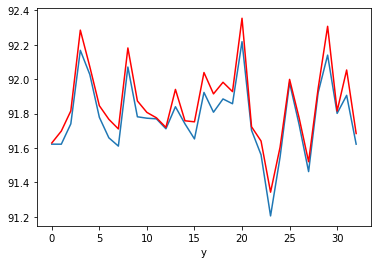

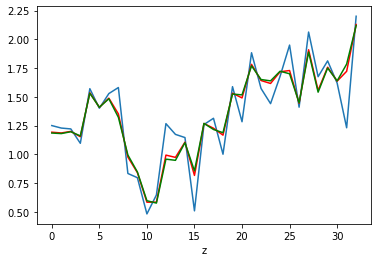

sigma_x_matlab: 0.072
sigma_x_new: 0.099

sigma_y_matlab: 0.116
sigma_y_new: 0.158

sigma_z_matlab: 0.278
sigma_z_new: 0.140
sigma_z_oil: 0.124
sigma_z_multfact: 0.081
z_mult: 1.783571028509114

PARTICLE ID:  4
training images shape (23, 64, 64, 2)
validation images shape (23, 64, 64, 1)
Generating 100 / 100 samples before starting training


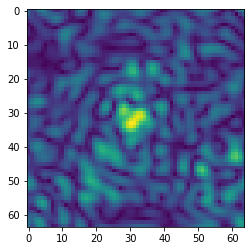

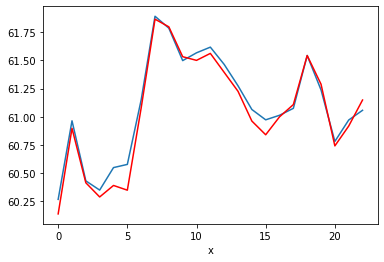

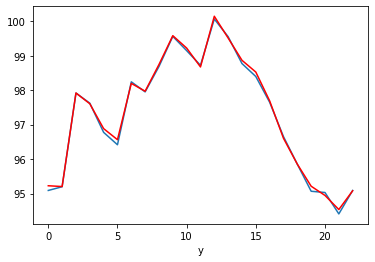

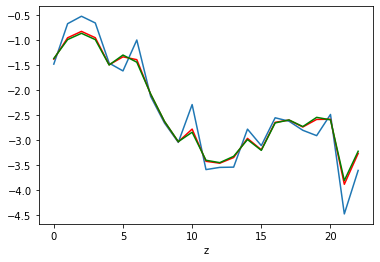

sigma_x_matlab: 0.059
sigma_x_new: 0.121

sigma_y_matlab: 0.170
sigma_y_new: 0.149

sigma_z_matlab: 0.440
sigma_z_new: 0.166
sigma_z_oil: 0.128
sigma_z_multfact: 0.076
z_mult: 1.3947889243601823

PARTICLE ID:  5
training images shape (29, 64, 64, 2)
validation images shape (29, 64, 64, 1)
Generating 101 / 100 samples before starting training


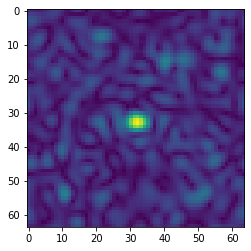

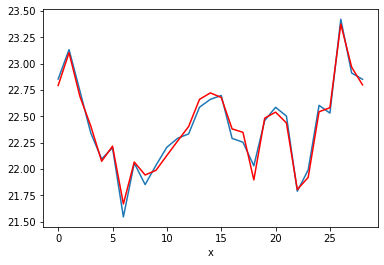

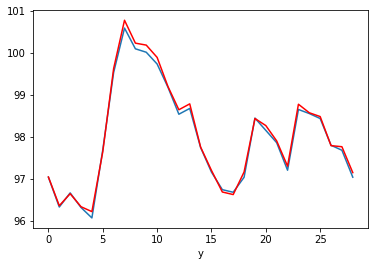

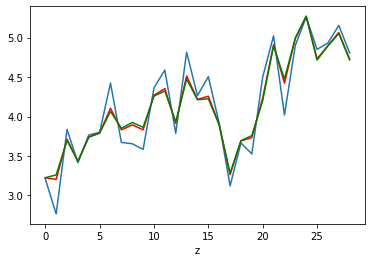

sigma_x_matlab: 0.181
sigma_x_new: 0.144

sigma_y_matlab: 0.404
sigma_y_new: 0.430

sigma_z_matlab: 0.395
sigma_z_new: 0.210
sigma_z_oil: 0.187
sigma_z_multfact: 0.115
z_mult: 1.966860530327123

PARTICLE ID:  6
training images shape (23, 64, 64, 2)
validation images shape (23, 64, 64, 1)
Generating 101 / 100 samples before starting training


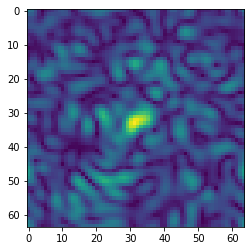

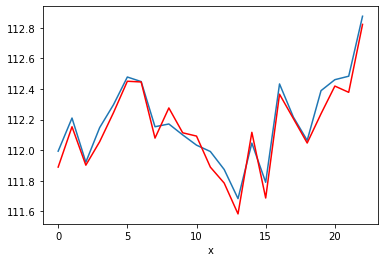

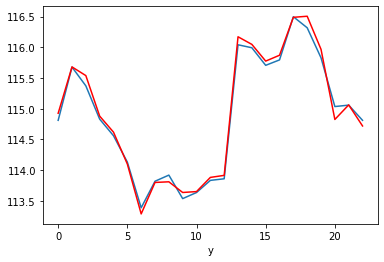

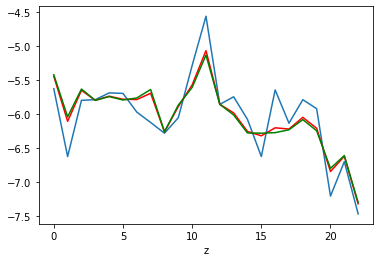

sigma_x_matlab: 0.152
sigma_x_new: 0.198

sigma_y_matlab: 0.151
sigma_y_new: 0.145

sigma_z_matlab: 0.384
sigma_z_new: 0.201
sigma_z_oil: 0.192
sigma_z_multfact: 0.208
z_mult: 1.2646609075405935

PARTICLE ID:  7
training images shape (18, 64, 64, 2)
validation images shape (18, 64, 64, 1)
Generating 101 / 100 samples before starting training


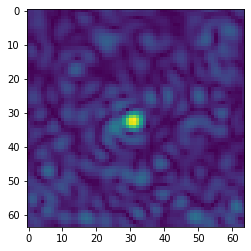

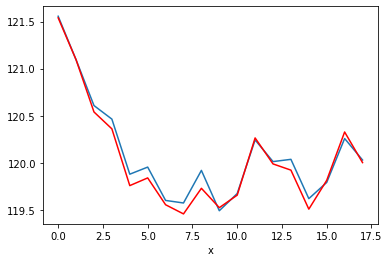

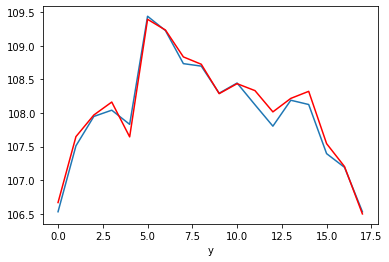

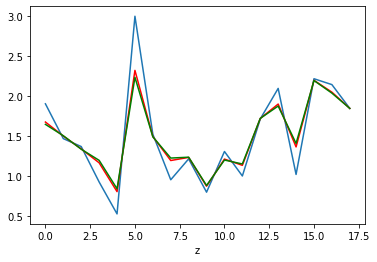

sigma_x_matlab: 0.060
sigma_x_new: 0.087

sigma_y_matlab: 0.071
sigma_y_new: 0.162

sigma_z_matlab: 0.605
sigma_z_new: 0.369
sigma_z_oil: 0.339
sigma_z_multfact: 0.231
z_mult: 2.515071184991253

PARTICLE ID:  8
training images shape (19, 64, 64, 2)
validation images shape (19, 64, 64, 1)
Generating 101 / 100 samples before starting training


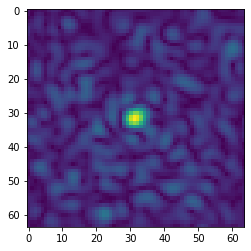

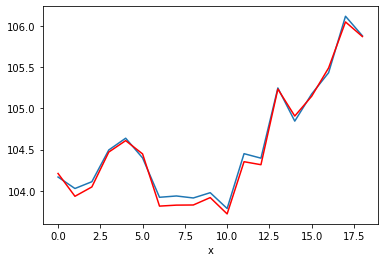

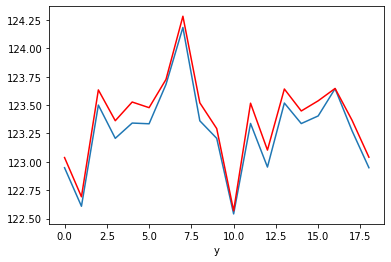

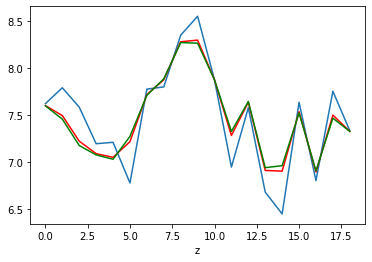

sigma_x_matlab: 0.163
sigma_x_new: 0.123

sigma_y_matlab: 0.320
sigma_y_new: 0.338

sigma_z_matlab: 0.431
sigma_z_new: 0.220
sigma_z_oil: 0.195
sigma_z_multfact: 0.118
z_mult: 1.8725788242866181

PARTICLE ID:  9
training images shape (32, 64, 64, 2)
validation images shape (32, 64, 64, 1)
Generating 100 / 100 samples before starting training


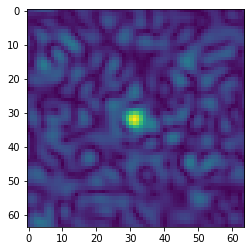

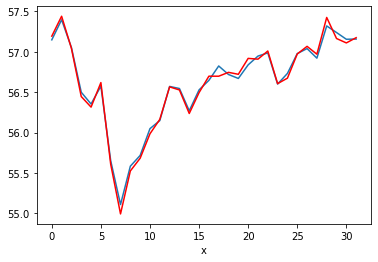

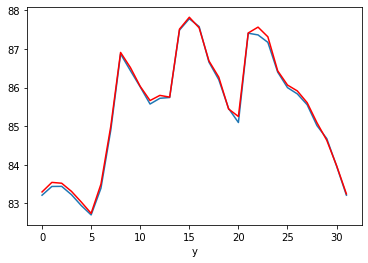

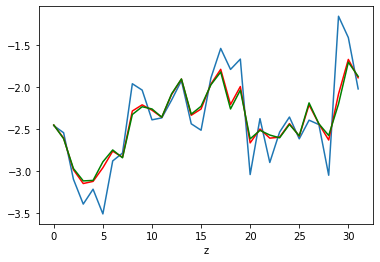

sigma_x_matlab: 0.092
sigma_x_new: 0.083

sigma_y_matlab: 0.443
sigma_y_new: 0.471

sigma_z_matlab: 0.321
sigma_z_new: 0.115
sigma_z_oil: 0.109
sigma_z_multfact: 0.162
z_mult: 1.1452465810936903

PARTICLE ID:  10
training images shape (64, 64, 64, 2)
validation images shape (64, 64, 64, 1)
Generating 101 / 100 samples before starting training


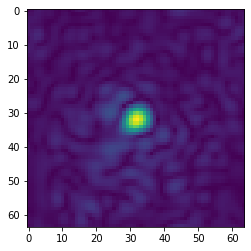

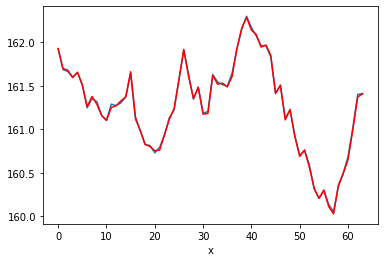

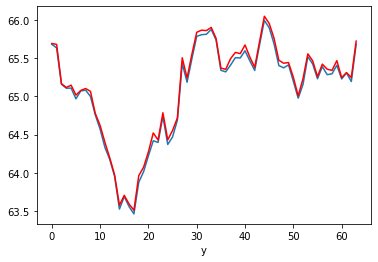

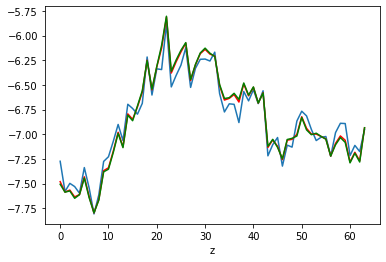

sigma_x_matlab: 0.085
sigma_x_new: 0.081

sigma_y_matlab: 0.065
sigma_y_new: 0.051

sigma_z_matlab: 0.138
sigma_z_new: 0.094
sigma_z_oil: 0.089
sigma_z_multfact: 0.073
z_mult: 2.3908271896429083

PARTICLE ID:  11
training images shape (16, 64, 64, 2)
validation images shape (16, 64, 64, 1)
Generating 100 / 100 samples before starting training


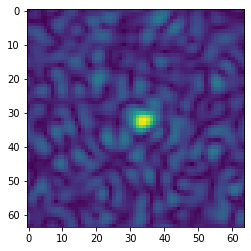

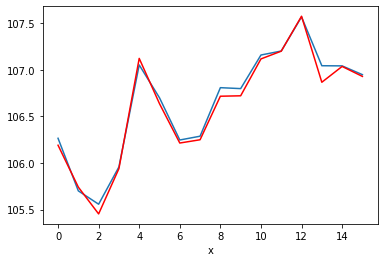

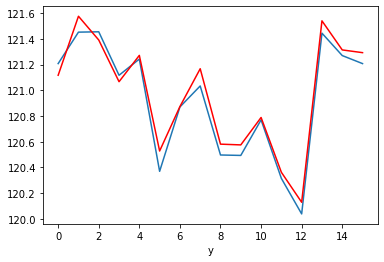

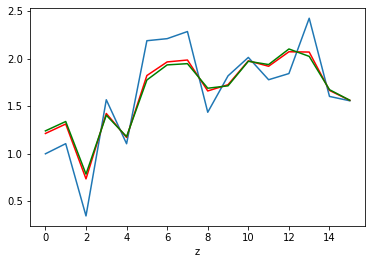

sigma_x_matlab: 0.070
sigma_x_new: 0.100

sigma_y_matlab: 0.295
sigma_y_new: 0.293

sigma_z_matlab: 0.450
sigma_z_new: 0.222
sigma_z_oil: 0.197
sigma_z_multfact: 0.130
z_mult: 1.732058852979711

PARTICLE ID:  12
training images shape (19, 64, 64, 2)
validation images shape (19, 64, 64, 1)
Generating 101 / 100 samples before starting training


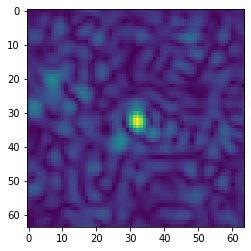

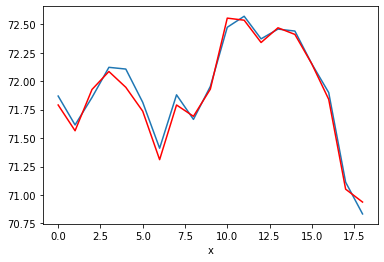

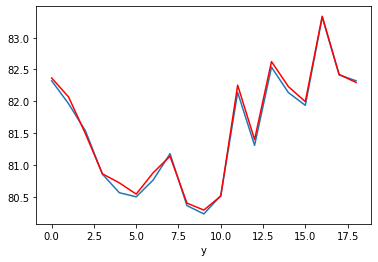

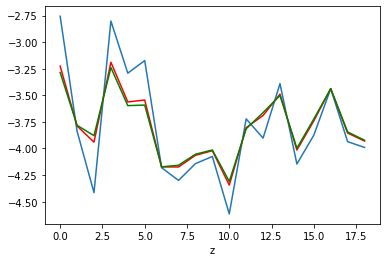

sigma_x_matlab: 0.159
sigma_x_new: 0.141

sigma_y_matlab: 0.440
sigma_y_new: 0.449

sigma_z_matlab: 0.391
sigma_z_new: 0.201
sigma_z_oil: 0.177
sigma_z_multfact: 0.088
z_mult: 2.0434114283724716

PARTICLE ID:  13
training images shape (18, 64, 64, 2)
validation images shape (18, 64, 64, 1)


KeyboardInterrupt: ignored

In [75]:
from scipy.optimize import minimize

original_model = models[-1]
def compare_lode_matlab(val_stack):
    out_sigmas_new = []
    out_sigmas_matlab = []
    z_mults = []
    for particle_id in range(len(val_stack)):
        print("PARTICLE ID: ", particle_id)

        training_images = np.stack((np.real(particles_timeseries[particle_id])[:,:,:,0], np.imag(particles_timeseries[particle_id][:,:,:,0])), axis=-1)
        print(f"training images shape {training_images.shape}")
        validation_set = particles_timeseries[particle_id][:,:,:,:]
        print(f"validation images shape {validation_set.shape}")

        training_set = create_training_set(training_images)

        generator = dt.models.lodestar.LodeSTARGenerator(
            training_set,
            num_outputs=num_outputs, 
            transformation_function=(group, equivariance), 
            batch_size=8, 
            min_data_size=100, 
            max_data_size=101,
        )

        model = original_model
        with generator:
            h = model.fit(generator, epochs=15, steps_per_epoch=50, verbose=0)


        timeseries = np.stack( (np.real(val_stack[particle_id][:,:,:,0]), np.imag(val_stack[particle_id][:,:,:,0])), axis=-1)
        corrections = predict_on_stack(model, timeseries)
        x_lode, y_lode, z_lode = corrections[:,0], corrections[:,1], corrections[:,2]
        x_matlab, y_matlab, z_matlab = particles_positions[particle_id][:,0], particles_positions[particle_id][:,1], particles_positions[particle_id][:,2]
        y_matlab = y_matlab - np.mean(np.diff(y_matlab))*np.array(range(len(y_matlab))) #####

        z_lode = z_lode/-10
        z_lode = z_lode - np.mean(z_lode)
        x_new, y_new, z_new = x_matlab+(32+x_lode)*0.114, y_matlab+(32+y_lode)*0.114, z_lode+z_matlab
        z_oil_maybe = z_matlab+z_lode*1.5/1.33
        z_shoudlnt = z_matlab+z_lode*1.6



        plt.imshow(np.abs(timeseries[0,:,:,0]+1j*timeseries[0,:,:,1]))
        plt.show()

        plt.plot(list(range(len(x_matlab))), x_matlab)
        plt.xlabel("x")
        plt.plot(list(range(len(x_lode))), x_new, 'r')
        plt.show()

        plt.plot(list(range(len(y_matlab))), y_matlab)
        plt.plot(list(range(len(y_lode))), y_new, 'r')
        plt.xlabel("y")
        plt.show()

        plt.plot(list(range(len(z_matlab))), z_matlab)
        plt.plot(list(range(len(z_lode))), z_new, 'r')
        plt.plot(list(range(len(z_oil_maybe))), z_oil_maybe, 'g')
        plt.xlabel("z")
        plt.show()

        print(f"sigma_x_matlab: {calc_sigma(x_matlab):.3f}")
        print(f"sigma_x_new: {calc_sigma(x_new):.3f}\n")

        print(f"sigma_y_matlab: {calc_sigma(y_matlab):.3f}")
        print(f"sigma_y_new: {calc_sigma(y_new):.3f}\n")

        print(f"sigma_z_matlab: {calc_sigma(z_matlab):.3f}")
        print(f"sigma_z_new: {calc_sigma(z_new):.3f}")
        print(f"sigma_z_oil: {calc_sigma(z_oil_maybe):.3f}")
        print(f"sigma_z_multfact: {calc_sigma(z_shoudlnt):.3f}")

        def sigma_z(x):
            arr = z_matlab + z_lode*x
            return calc_sigma(arr)

        z_mult = minimize(sigma_z, [1], method="Powell").x
        print(f"z_mult: {z_mult}\n")

        out_sigmas_new.append([calc_sigma(x_new), calc_sigma(y_new), calc_sigma(z_new)])
        out_sigmas_matlab.append([calc_sigma(x_matlab), calc_sigma(y_matlab), calc_sigma(z_matlab)])
        z_mults.append(z_mult)
    return np.array(out_sigmas_new), np.array(out_sigmas_matlab), z_mults

new_sigmas, matlab_sigmas, z_mults = compare_lode_matlab(particles_timeseries)
print(f"optimal mult.factor: {np.mean(z_mults)}")

In [ ]:

def id_new_better_than_matlab(new_sigmas, matlab_sigmas):
    out = []
    for i in range(new_sigmas.shape[0]):
        #print(i, f"   {np.linalg.norm(new_sigmas[i,:])/np.linalg.norm(matlab_sigmas[i,:]):.2f}", f"   {np.linalg.norm(new_sigmas[i,2])/np.linalg.norm(matlab_sigmas[i,2]):.2f}")
        if np.linalg.norm(new_sigmas[i,2]) < np.linalg.norm(matlab_sigmas[i,2]):
            out.append(i)
    return out


#OPTIMAL MULT.FAKTOR: 1.600333833

bin = np.linspace(0,0.5,10)
ids = id_new_better_than_matlab(new_sigmas, matlab_sigmas)
print(len(ids), len(particles_timeseries))
print(f"korrigerad sigma_z: {np.mean(new_sigmas[ids,2])}, matlabs sigma_z: {np.mean(matlab_sigmas[ids,2])}")
print(np.mean(new_sigmas[ids,0]), np.mean(matlab_sigmas[ids,0]))